<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture2/histrical_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 有名なモデルを実装

In [1]:
# googleドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Deep_Learning/DL_Lecture2

/content/drive/MyDrive/Deep_Learning/DL_Lecture2


In [3]:
import torch
from torch.nn import functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import models, transforms
from torchvision.models.vgg import VGG11_Weights

%load_ext autoreload
%autoreload 2
import utils

### LeNet

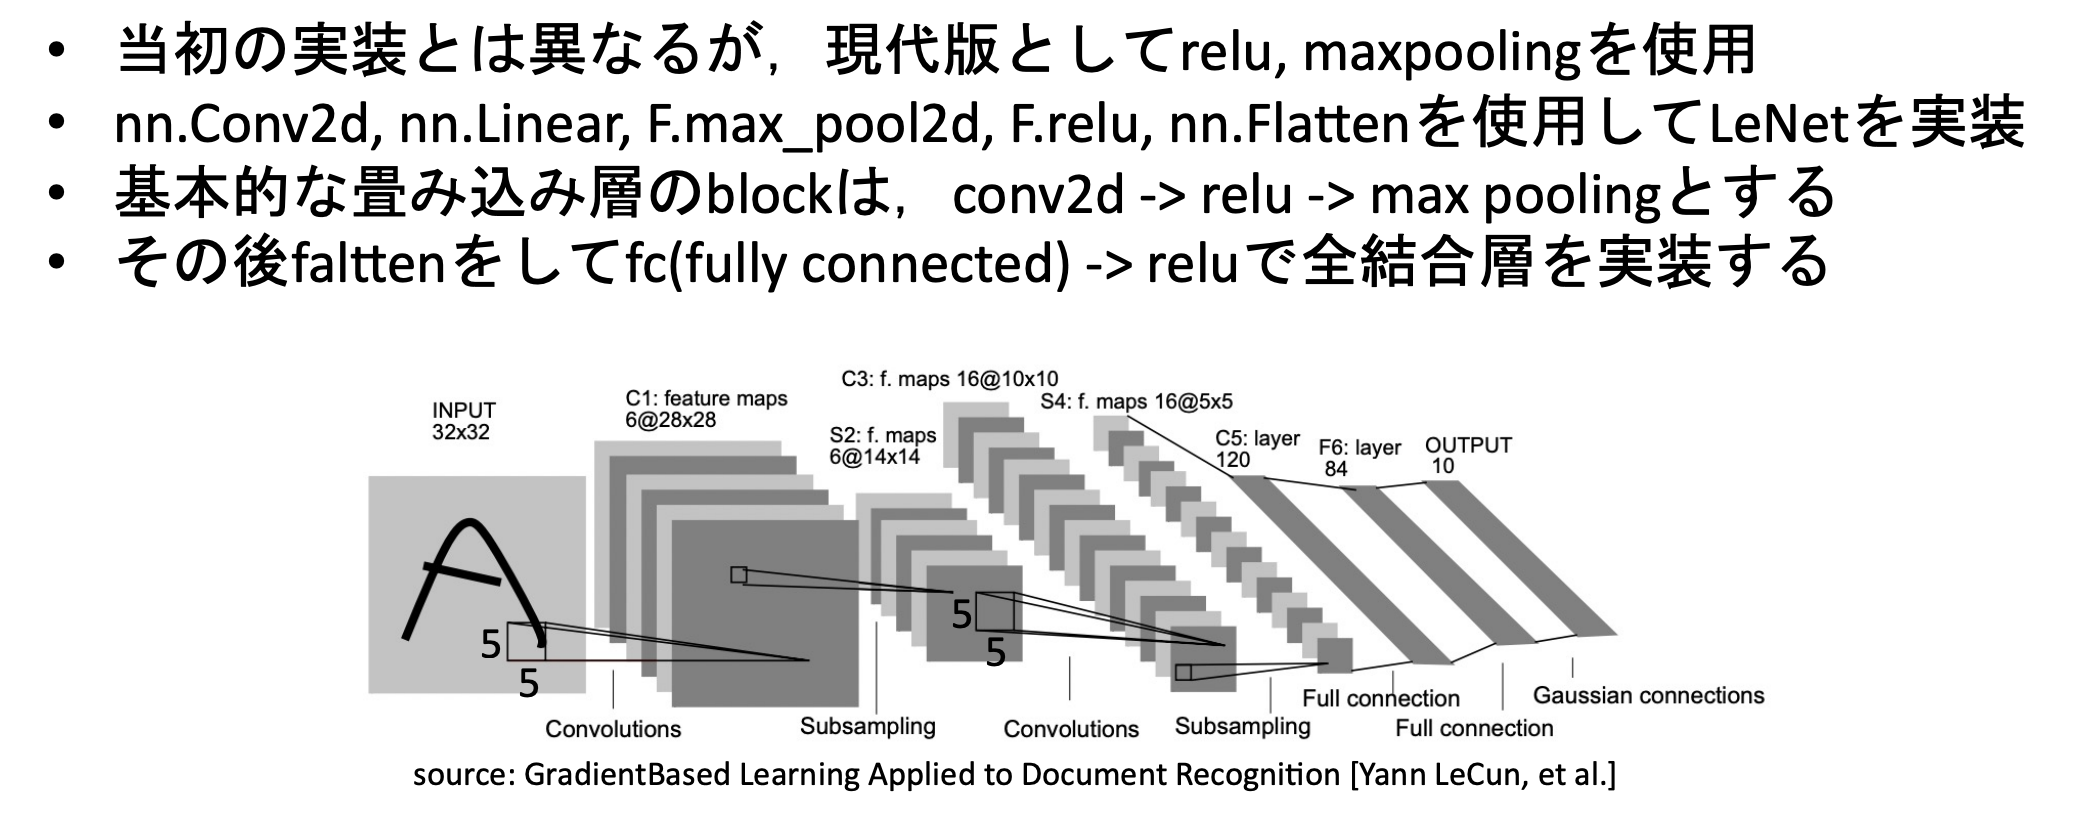

In [4]:
class LeNet(nn.Module):
    def __init__(self, input_channel, num_classes):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channel, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.pool = nn.MaxPool2d(kernel_size=2) # --> ストライドは設定しなければ、自動的にカーネルサイズと同じ値が適用される
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
lenet = LeNet(1, 10)
X = torch.randn((128, 1, 32, 32))
out = lenet(X)
out.shape

torch.Size([128, 10])

### 既存モデルの使用

In [6]:
model = models.vgg11(weights=VGG11_Weights.IMAGENET1K_V1)
model.classifier

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth
100%|██████████| 507M/507M [00:03<00:00, 171MB/s]


Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [7]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # CIFAR10用
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
train_dataset = torchvision.datasets.CIFAR10('./cifar10_data', train=True, download=True, transform=transform)
val_dataset = torchvision.datasets.CIFAR10('./cifar10_data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# データ量が多くて学習できない場合はサブデータを使用する
# train_dataset_sub = Subset(train_dataset, range(500))
# val_dataset_sub = Subset(val_dataset, range(250))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
# 最終層の出力を10クラス分類用にする
model.classifier[-1] = nn.Linear(4096, 10)

In [10]:
# GPUで学習する場合は以下のように.to(device)でGPUにモデルを移動させる
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
opt = optim.SGD(model.parameters(), lr=0.03)

In [11]:
import time
start = time.time()
train_losses, val_losses, val_accuracies = utils.learn(model, train_loader, val_loader, opt, F.cross_entropy, 3)
end = time.time()
print(end - start)

epoch: 0: train error: 1.023575985774994, validation error: 0.6480403050780297, validation accuracy: 0.7922


epoch: 1: train error: 0.5577167255479097, validation error: 0.5883511111736298, validation accuracy: 0.8091


epoch: 2: train error: 0.3954883476035297, validation error: 0.5100268945574761, validation accuracy: 0.8357
238.01539659500122
